In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
class EmotionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [3]:
def load_emotion_data(train_path, test_path):
    try:
        train_df = pd.read_excel(train_path)
        test_df = pd.read_excel(test_path)
        
        print(f"Loaded training data: {len(train_df)} samples")
        print(f"Loaded testing data: {len(test_df)} samples")
        
        feature_columns = ['left_eye_ar', 'right_eye_ar', 'mouth_ar',	
                           'mouth_openness', 'left_eyebrow_pos', 'right_eyebrow_pos',	
                           'smile_ratio', 'nose_wrinkle', 'eye_symmetry', 'eyebrow_symmetry']
        
        label_column = 'emotion'
        
        # Extract features and labels
        X_train = train_df[feature_columns].values
        X_test = test_df[feature_columns].values
        
        # Encode labels
        with open('/kaggle/input/label-encoderr/label_encoder (1).pkl','rb') as file:
            label_encoder = pickle.load(file)
        y_train = label_encoder.transform(train_df[label_column])
        y_test = label_encoder.transform(test_df[label_column])
        
        print("\nDataset Statistics:")
        print(f"Total training samples: {len(train_df)}")
        print(f"Total testing samples: {len(test_df)}")
        print("\nTraining samples per emotion:")
        print(train_df[label_column].value_counts())
        print("\nTesting samples per emotion:")
        print(test_df[label_column].value_counts())
        
        return X_train, X_test, y_train, y_test, label_encoder
    
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

In [4]:
class EmotionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_classes=8, dropout_rate=0.3):
        super(EmotionLSTM, self).__init__()
        
        # Simplified architecture - one bidirectional LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Simple dense layers
        self.bn = nn.BatchNorm1d(hidden_size*2)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # Get last time step or squeeze
        if lstm_out.size(1) == 1:
            lstm_out = lstm_out.squeeze(1)
        else:
            lstm_out = lstm_out[:, -1, :]
        
        # Apply batch normalization
        lstm_out = self.bn(lstm_out)
        lstm_out = self.dropout(lstm_out)
        
        # Dense layers
        x = self.fc1(lstm_out)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [5]:
class EmotionDetectionPyTorch:
    def __init__(self, X_train, X_test, y_train, y_test, label_encoder):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # Standardize features
        self.scaler = RobustScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        # Reshape for LSTM (samples, sequence_length, features)
        self.X_train_reshaped = self.X_train_scaled.reshape(
            (self.X_train_scaled.shape[0], 1, self.X_train_scaled.shape[1]))
        self.X_test_reshaped = self.X_test_scaled.reshape(
            (self.X_test_scaled.shape[0], 1, self.X_test_scaled.shape[1]))
        
        self.label_encoder = label_encoder
        self.num_classes = len(label_encoder.classes_)
        
        # Set device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        # Create datasets and dataloaders
        self.train_dataset = EmotionDataset(self.X_train_reshaped, self.y_train)
        self.test_dataset = EmotionDataset(self.X_test_reshaped, self.y_test)
        
        self.results = {}
        
        print(f"\nTraining set shape: {self.X_train.shape}")
        print(f"Testing set shape: {self.X_test.shape}")

    def create_dataloaders(self, batch_size=32):
        """Create DataLoaders for train and test sets"""
        train_loader = DataLoader(
            self.train_dataset, 
            batch_size=batch_size, 
            shuffle=True
        )
        
        test_loader = DataLoader(
            self.test_dataset,
            batch_size=batch_size,
            shuffle=False
        )
        
        return train_loader, test_loader
    
    def create_lstm_model(self):
        """Create LSTM model"""
        input_dim = self.X_train.shape[1]  # Number of features
        hidden_dim = 128
        model = EmotionLSTM(input_size=self.X_train.shape[1])
        model.to(self.device)
        return model
    
    def train_model(self, model, train_loader, test_loader, epochs=1000, learning_rate=0.0005):
        """Train the PyTorch model"""

        # Create loss function with weights
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # For tracking metrics
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []
        
        print(f"\nTraining LSTM model...")
        for epoch in range(epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = correct / total
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)
            
            # Validation phase
            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    val_running_loss += loss.item() * inputs.size(0)
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            val_epoch_loss = val_running_loss / len(test_loader.dataset)
            val_epoch_acc = val_correct / val_total
            val_losses.append(val_epoch_loss)
            val_accs.append(val_epoch_acc)
            
            # Print statistics
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{epochs} - "
                      f"Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} - "
                      f"Val Loss: {val_epoch_loss:.4f} - Val Acc: {val_epoch_acc:.4f}")
        
        history = {
            'loss': train_losses,
            'accuracy': train_accs,
            'val_loss': val_losses,
            'val_accuracy': val_accs
        }
        
        return model, history
    
    def evaluate_model(self, model, test_loader):
        """Evaluate the model on test data"""
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Convert indices to emotion labels
        pred_emotions = self.label_encoder.inverse_transform(all_preds)
        true_emotions = self.label_encoder.inverse_transform(all_labels)
        
        # Calculate metrics
        conf_matrix = confusion_matrix(true_emotions, pred_emotions)
        class_report = classification_report(true_emotions, pred_emotions)
        
        return conf_matrix, class_report, pred_emotions, true_emotions
    
    def plot_confusion_matrix(self, conf_matrix, title, emotion_labels):
        """Plot confusion matrix"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=emotion_labels, yticklabels=emotion_labels)
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def plot_training_history(self, history, title):
        """Plot training history"""
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Training Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{title} - Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title(f'{title} - Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def run_experiment(self, model_name="LSTM", batch_size=32, epochs=1500, learning_rate=0.0005):
        """Run a complete experiment"""
        # Create dataloaders
        train_loader, test_loader = self.create_dataloaders(batch_size)
        
        # Create model
        model = self.create_lstm_model()
        
        # Train model
        trained_model, history = self.train_model(
            model, train_loader, test_loader, epochs, learning_rate
        )
        
        # Evaluate model
        conf_matrix, class_report, pred_emotions, true_emotions = self.evaluate_model(
            trained_model, test_loader
        )
        
        # Store results
        self.results[model_name] = {
            'model': trained_model,
            'history': history,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report,
            'predictions': pred_emotions,
            'true_labels': true_emotions
        }
        
        # Plot results
        self.plot_training_history(history, model_name)
        self.plot_confusion_matrix(
            conf_matrix, f'{model_name} Confusion Matrix', 
            self.label_encoder.classes_
        )
        
        print(f"\n{model_name} Classification Report:")
        print(class_report)
        
        return trained_model
    
    def print_comparison(self):
        """Print comparison of different models"""
        print("\nModel Comparison Results")
        print("=" * 50)
        
        summary_data = []
        
        for model_name, result in self.results.items():
            print(f"\n{model_name} Results")
            print("-" * 30)
            print("\nClassification Report:")
            print(result['classification_report'])
            
            val_acc = result['history']['val_accuracy'][-1]
            val_loss = result['history']['val_loss'][-1]
            
            summary_data.append({
                'Model': model_name,
                'Validation Accuracy': val_acc,
                'Validation Loss': val_loss
            })
        
        summary_df = pd.DataFrame(summary_data)
        print("\nSummary of Results:")
        print(summary_df.to_string(index=False))

    def save_model(self, model, path='/kaggle/working/emotion_lstm_model.pth'):
        """Save the PyTorch model"""
        torch.save(model.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path='/kaggle/working/emotion_lstm_model.pth'):
        """Load a saved PyTorch model"""
        model = self.create_lstm_model()
        model.load_state_dict(torch.load(path, map_location=self.device))
        model.eval()
        return model

Loaded training data: 2315 samples
Loaded testing data: 565 samples

Dataset Statistics:
Total training samples: 2315
Total testing samples: 565

Training samples per emotion:
emotion
angry        320
fearful      313
disgust      313
surprised    309
calm         307
sad          307
happy        294
neutral      152
Name: count, dtype: int64

Testing samples per emotion:
emotion
happy        90
calm         77
sad          77
surprised    75
fearful      71
disgust      71
angry        64
neutral      40
Name: count, dtype: int64
Using device: cpu

Training set shape: (2315, 10)
Testing set shape: (565, 10)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



Training LSTM model...
Epoch 1/1500 - Loss: 1.7718 - Acc: 0.3248 - Val Loss: 1.5901 - Val Acc: 0.4283
Epoch 5/1500 - Loss: 1.4858 - Acc: 0.4298 - Val Loss: 1.3767 - Val Acc: 0.4496
Epoch 10/1500 - Loss: 1.4122 - Acc: 0.4540 - Val Loss: 1.3288 - Val Acc: 0.5186
Epoch 15/1500 - Loss: 1.3753 - Acc: 0.4734 - Val Loss: 1.2870 - Val Acc: 0.5027
Epoch 20/1500 - Loss: 1.3361 - Acc: 0.4769 - Val Loss: 1.2481 - Val Acc: 0.5646
Epoch 25/1500 - Loss: 1.3143 - Acc: 0.5028 - Val Loss: 1.2291 - Val Acc: 0.5575
Epoch 30/1500 - Loss: 1.2739 - Acc: 0.5166 - Val Loss: 1.2000 - Val Acc: 0.5434
Epoch 35/1500 - Loss: 1.2491 - Acc: 0.5287 - Val Loss: 1.1587 - Val Acc: 0.5858
Epoch 40/1500 - Loss: 1.2029 - Acc: 0.5464 - Val Loss: 1.1470 - Val Acc: 0.6088
Epoch 45/1500 - Loss: 1.1910 - Acc: 0.5421 - Val Loss: 1.1248 - Val Acc: 0.6088
Epoch 50/1500 - Loss: 1.1662 - Acc: 0.5594 - Val Loss: 1.1234 - Val Acc: 0.6088
Epoch 55/1500 - Loss: 1.1389 - Acc: 0.5676 - Val Loss: 1.0619 - Val Acc: 0.6159
Epoch 60/1500 - Lo

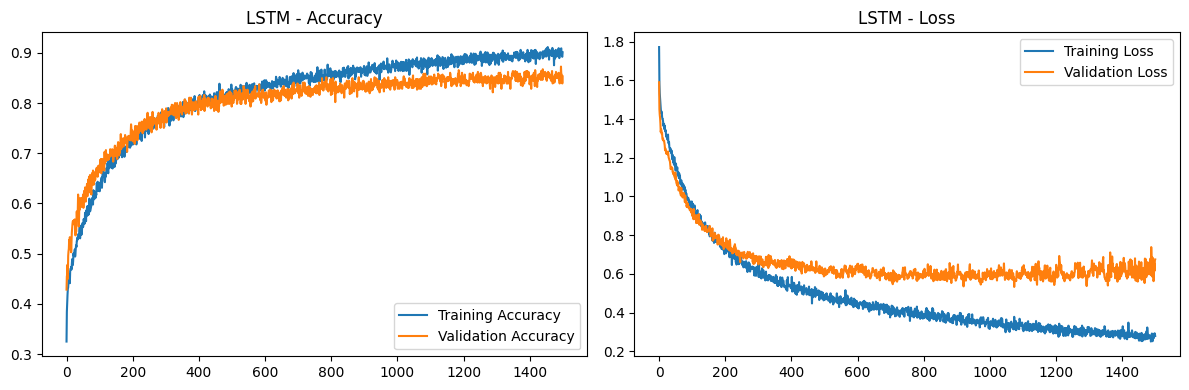

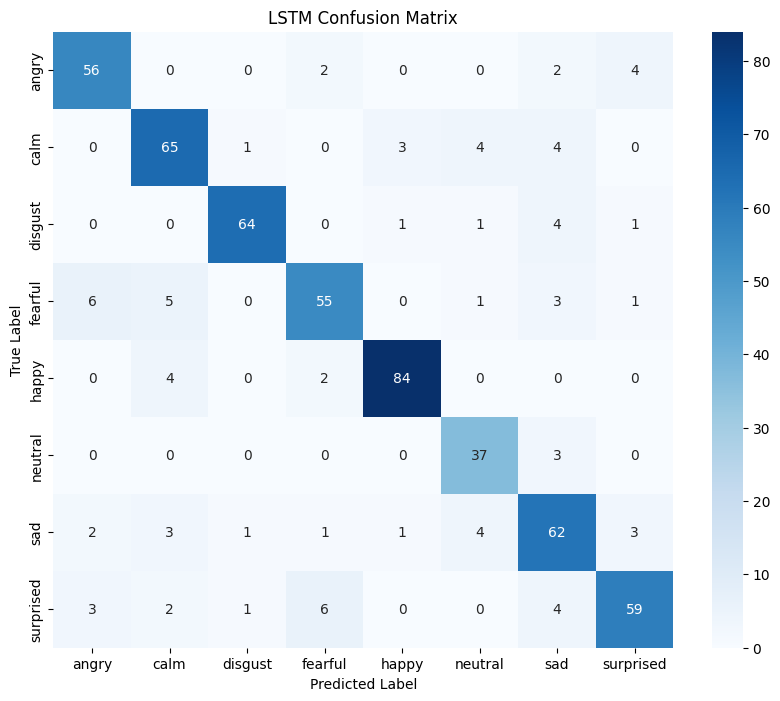


LSTM Classification Report:
              precision    recall  f1-score   support

       angry       0.84      0.88      0.85        64
        calm       0.82      0.84      0.83        77
     disgust       0.96      0.90      0.93        71
     fearful       0.83      0.77      0.80        71
       happy       0.94      0.93      0.94        90
     neutral       0.79      0.93      0.85        40
         sad       0.76      0.81      0.78        77
   surprised       0.87      0.79      0.83        75

    accuracy                           0.85       565
   macro avg       0.85      0.86      0.85       565
weighted avg       0.86      0.85      0.85       565

Model saved to /kaggle/working/emotion_lstm_model.pth

Model Comparison Results

LSTM Results
------------------------------

Classification Report:
              precision    recall  f1-score   support

       angry       0.84      0.88      0.85        64
        calm       0.82      0.84      0.83        77
     dis

In [6]:
if __name__ == "__main__":
    train_path = "/kaggle/input/mediapipe-face-mesh-features1/FaceTrain_new.xlsx"
    test_path = "/kaggle/input/mediapipe-face-mesh-features1/FaceTest_new.xlsx"
    
    X_train, X_test, y_train, y_test, label_encoder = load_emotion_data(train_path, test_path)

    emotion_detector = EmotionDetectionPyTorch(X_train, X_test, y_train, y_test, label_encoder)
    
    model = emotion_detector.run_experiment() 
    
    emotion_detector.save_model(model)

    emotion_detector.print_comparison()